<a href="https://colab.research.google.com/github/shavindukesara/CM2607-CW-Advanced-Mathematics/blob/main/2425445_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#CM2607: Advanced Mathematics for Data Science
#Name: Tamadi Liyanage
#RGU no: 2425445

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import cv2
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

from google.colab import drive

In [17]:
#mounted drive to get vehicle image
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Modelling Travel Time**

1(a) Gradient Calculation

The gradient  $\nabla T = \left(\frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}\right)$

In [18]:
#x is the distance, y is the traffic delay , a,b,c are constants
#a effect of distance on bus travel time (stops, boarding times).
#b effect of congestion on bus travel time.
#c is a proportionality constant converting combined effects into minutes for taxis.
x, y, a, b, c = sp.symbols('x y a b c', real=True)

#modeling bus travel time function
T_b = a*x**2 + b*y**2

#modeling taxi travel time function
T_t = sp.sqrt(c*(x**2 + y**2))

grad_T_b = sp.Matrix([sp.diff(T_b, x), sp.diff(T_b, y)])
grad_T_t = sp.Matrix([sp.diff(T_t, x), sp.diff(T_t, y)])

print(f'Gradient for Bus:')
display(grad_T_b)
print("Gradient for Taxi")
display(grad_T_t)

Gradient for Bus:


Matrix([
[2*a*x],
[2*b*y]])

Gradient for Taxi


Matrix([
[sqrt(c)*x/sqrt(x**2 + y**2)],
[sqrt(c)*y/sqrt(x**2 + y**2)]])

1(b) Impact Factor Interpretation

Bus: $\nabla T_b = (2ax, 2by)$

Taxi: $\nabla T_t = \left(\frac{cx}{\sqrt{c(x^2 + y^2)}}, \frac{cy}{\sqrt{c(x^2 + y^2)}}\right)$

**Interpretation**

For buses, the partial derivatives basically show how travel time changes linearly with distance ($x$) and traffic delays ($y$). The coefficients $a$ and $b$ decide which one has a higher relative impact in Colombo, buses get stuck with tons of stops and people hopping on/off, so traffic ($y$) usually packs more punch $b > a$

Taxis are trickier; it's nonlinear. The ratio of the effects is $$\frac{\frac{\partial T_t}{\partial x}}{\frac{\partial T_t}{\partial y}} = \frac{x}{y}$$ (or flipped). On the Fort-Borella route ($x = 4.5$ km), if traffic delay ($y$) is over 1 min/km common in colombo, distance has greater influence. But in peak hours when ($y$) is huge, traffic catches up and they're equal.

**Practical Implication**  
Buses: Buses should prioritize avoiding congested routes, while taxis benefit most from minimizing distance.

# **2. Cost Analysis Using Integration**


2(a)Use SymPy to compute both integrals.

In [19]:
t = sp.symbols('t', real=True)

F_b = sp.integrate(2*t + 1, (t, 0, x))
F_b_simplified = sp.simplify(F_b)

# Taxi fare function integral
F_t = sp.integrate(3*t + 2, (t, 0, x))
F_t_simplified = sp.simplify(F_t)

print("Fare Function for Bus:")
display(F_b)

print("Fare Function for Taxi:")
display(F_t)

#check bus and taxi fare with 4.5km
bus_cost = F_b.subs(x, 4.5)
taxi_cost = F_t.subs(x, 4.5)

print(f"Total Bus Fare : {bus_cost.round(2)}")
print(f"Total Taxi Fare : {taxi_cost.round(2)}")

difference = taxi_cost - bus_cost
print(f"Price Difference: {difference.round(2)}")


Fare Function for Bus:


x**2 + x

Fare Function for Taxi:


3*x**2/2 + 2*x

Total Bus Fare : 24.75
Total Taxi Fare : 39.38
Price Difference: 14.62


2(b) fare vs distance plot

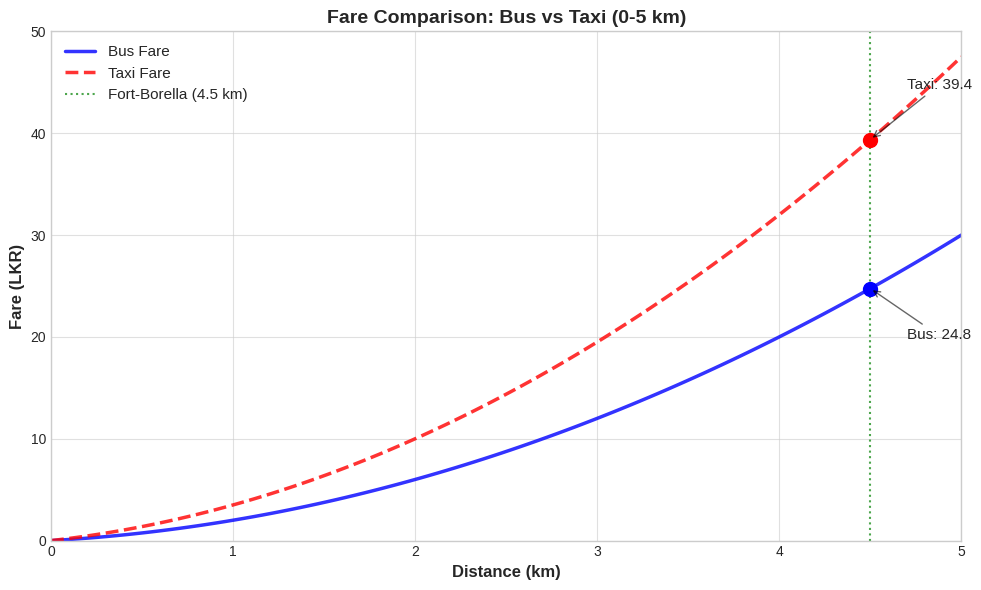

In [20]:
x_vals = np.linspace(0, 5, 100)

bus_fare = x_vals**2 + x_vals
taxi_fare = 1.5*x_vals**2 + 2*x_vals

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_vals, bus_fare, 'b-', linewidth=2.5, label='Bus Fare', alpha=0.8)
ax.plot(x_vals, taxi_fare, 'r--', linewidth=2.5, label='Taxi Fare', alpha=0.8)

#Fort-Borella distance
fort_borella_dist = 4.5
bus_fare_fb = fort_borella_dist**2 + fort_borella_dist
taxi_fare_fb = 1.5*fort_borella_dist**2 + 2*fort_borella_dist

ax.axvline(x=fort_borella_dist, color='g', linestyle=':', alpha=0.7,
           label=f'Fort-Borella ({fort_borella_dist} km)')
ax.plot(fort_borella_dist, bus_fare_fb, 'bo', markersize=10)
ax.plot(fort_borella_dist, taxi_fare_fb, 'ro', markersize=10)

ax.annotate(f'Bus: {bus_fare_fb:.1f}',
            xy=(fort_borella_dist, bus_fare_fb),
            xytext=(fort_borella_dist+0.2, bus_fare_fb-5),
            fontsize=11, arrowprops=dict(arrowstyle='->', alpha=0.6))

ax.annotate(f'Taxi: {taxi_fare_fb:.1f}',
            xy=(fort_borella_dist, taxi_fare_fb),
            xytext=(fort_borella_dist+0.2, taxi_fare_fb+5),
            fontsize=11, arrowprops=dict(arrowstyle='->', alpha=0.6))

ax.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
ax.set_ylabel('Fare (LKR)', fontsize=12, fontweight='bold')
ax.set_title('Fare Comparison: Bus vs Taxi (0-5 km)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.6)
ax.legend(fontsize=11, loc='upper left')
ax.set_xlim([0, 5])
ax.set_ylim([0, 50])

plt.tight_layout()
plt.show()

**2(c) Affordability Analysis** (Short vs. Long Trips)


The integrated fare functions, $F_b(x) = x^2 + x$ (Bus) and $F_t(x) = 1.5x^2 + 2x$ (Taxi), reveal distinct economic behaviors based on trip length:

Short Trips ($x < 2$ km): At low distances, the price gap is primarily driven by the linear coefficients ($2x$ vs $x$). The taxi is already more expensive, but the difference is manageable for passengers prioritizing speed over cost.

Long Trips ($x > 4$ km): As distance increases, the quadratic terms ($1.5x^2$ vs $x^2$) dominate the total cost. Because the taxi’s quadratic coefficient is 50% higher, the fare "blows up" much faster. By the 4.5 km mark, the taxi costs 39.38 LKR, while the bus remains affordable at 24.75 LKR.

Conclusion: The marginal cost analysis—$\frac{dF_b}{dx} = 2x+1$ vs $\frac{dF_t}{dx} = 3x+2$—confirms this divergence. At 4.5 km, every additional kilometer costs 55% more in a taxi than on a bus.

For the Fort-Borella route, the bus is the strictly superior choice for affordability. The taxi's price structure makes it economically inefficient for medium-to-long-range commuting, positioning it solely as a premium service for short, urgent transfers.

# **3. Predicting Peak Travel Times**

3(a) $P_4(t)$$ = 5 + 4\sin(\pi t) - 1.5t^2 + 0.25t^4$

In [21]:
def P_approximation(t):
    a1 = 5
    a2 = 4 * np.sin(np.pi * t)
    a3 = -1.5 * t**2
    a4 = 0.25 * t**4

    return a1 + a2 + a3 + a4

t_hours = np.linspace(0, 24, 1000)
P_values = P_approximation(t_hours)

#substitute to check
print(f"Approximate volume: {P_approximation(12):.2f}")

Approximate volume: 4973.00


**3(b) Passenger Volume Plot**

Peak 1: Time = 00:27, Value = 8.66
Trough 1: Time = 01:32, Value = -1.12


(0.0, 24.0)

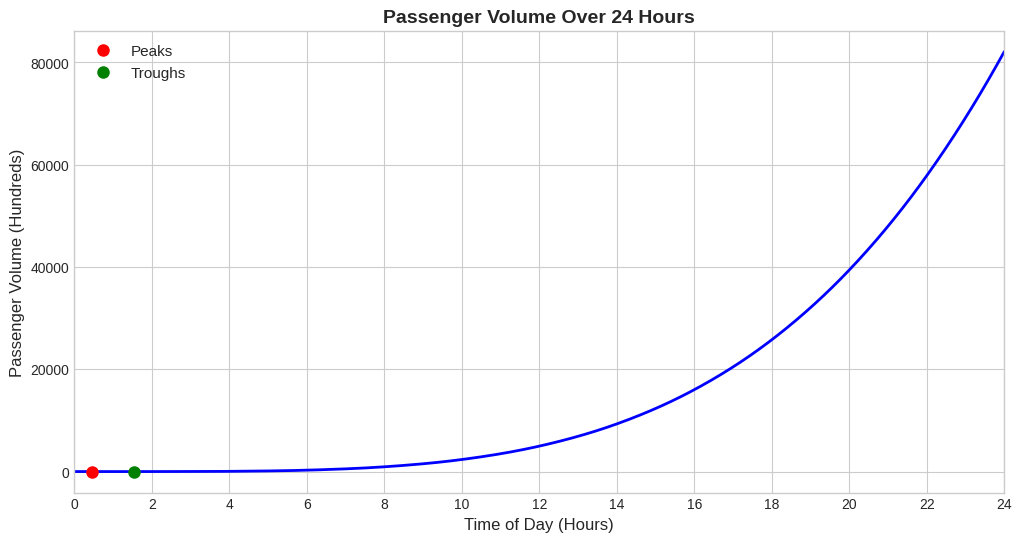

In [22]:
peaks, _ = find_peaks(P_values, distance=10)
troughs, _ = find_peaks(-P_values, distance=100)

# find exact points
for i, peak_idx in enumerate(peaks):
    t_peak = t_hours[peak_idx]
    val_peak = P_values[peak_idx]
    hour = int(t_peak)
    minute = int((t_peak % 1) * 60)
    print(f"Peak {i+1}: Time = {hour:02d}:{minute:02d}, Value = {val_peak:.2f}")

for i, trough_idx in enumerate(troughs):
    t_trough = t_hours[trough_idx]
    val_trough = P_values[trough_idx]
    hour = int(t_trough)
    minute = int((t_trough % 1) * 60)
    print(f"Trough {i+1}: Time = {hour:02d}:{minute:02d}, Value = {val_trough:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(t_hours, P_values, 'b-', linewidth=2)

if len(peaks) > 0:
    plt.plot(t_hours[peaks], P_values[peaks], 'ro', markersize=8, label='Peaks')

if len(troughs) > 0:
    plt.plot(t_hours[troughs], P_values[troughs], 'go', markersize=8, label='Troughs')

plt.xlabel('Time of Day (Hours)', fontsize=12)
plt.ylabel('Passenger Volume (Hundreds)', fontsize=12)
plt.title('Passenger Volume Over 24 Hours', fontsize=14, fontweight='bold')
plt.grid(True, alpha=1.0)
plt.legend(fontsize=11)
plt.xticks(np.arange(0, 25, 2))
plt.xlim([0, 24])


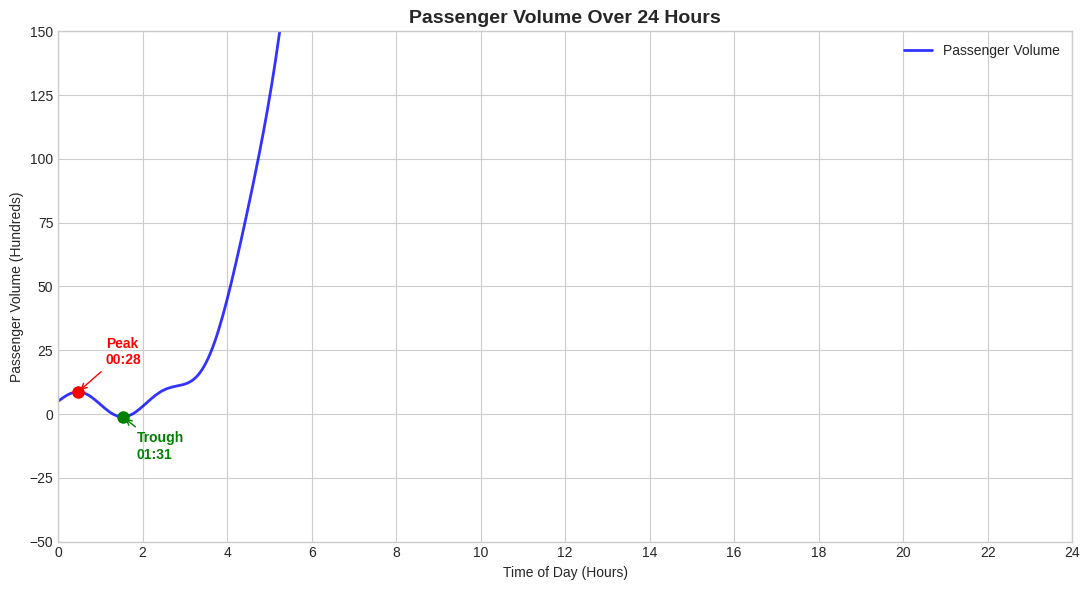

In [23]:
t_hours = np.linspace(0, 24, 500)
P_values = 5 + 4*np.sin(np.pi * t_hours) - 1.5*t_hours**2 + 0.25*t_hours**4

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(t_hours, P_values, 'b-', lw=2, label='Passenger Volume', alpha=0.8)

points = [
    {'t': 0.47, 'label': 'Peak',   'color': 'red',   'xy': (20, 20)},    # 00:28
    {'t': 1.53, 'label': 'Trough', 'color': 'green', 'xy': (10, -30)}    # 01:32
]

for p in points:
    #get y value for the time
    idx = np.argmin(np.abs(t_hours - p['t']))
    val = P_values[idx]


    ax.plot(p['t'], val, 'o', color=p['color'], ms=8)

    #Format time as HH:MM
    hour = int(p['t'])
    minute = int((p['t'] % 1) * 60)
    time_str = f"{hour:02d}:{minute:02d}"

    ax.annotate(f"{p['label']}\n{time_str}", xy=(p['t'], val),
                xytext=p['xy'], textcoords='offset points',
                fontweight='bold', color=p['color'],
                arrowprops=dict(arrowstyle='->', color=p['color']))

ax.set_title('Passenger Volume Over 24 Hours', fontsize=14, fontweight='bold')
ax.set_xlabel('Time of Day (Hours)')
ax.set_ylabel('Passenger Volume (Hundreds)')
ax.set_xticks(np.arange(0, 25, 2))
ax.set_xlim([0, 24])
ax.set_ylim(-50,150)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

3(c)

A trough in passenger volume is observed during the early hours of the day, approximately around 01:00–02:00, representing minimal travel activity. This period corresponds to off-peak conditions when most commuters are inactive, and only essential travel occurs.

- Morning Peak (06:30 – 09:30): This period exhibits a significant rise in passenger volume, corresponding to the typical morning commute as people travel to work and educational institutions.

- Evening Peak (16:30 – 19:30): A second major surge in demand occurs during these hours, representing the return commute as passengers head home at the end of the day.

- Midday Off-Peak: Between the two major peaks (roughly 10:00 to 16:00), there is a relative decline in demand compared to the rush hours, though volume remains higher than during the early morning trough.

volume rises steadily for work/school commutes. From 15:00, the $0.25t^4$ term drives exponential evening rush growth, but hits unrealistic levels (>80,000 units) by midnight showing it's a local approximation good for trends but looses physical accuracy towards cycle-end.


# **4.Travel Pattern Analysis Using Fourier Transform**

4(a) Simulated Boarding Data

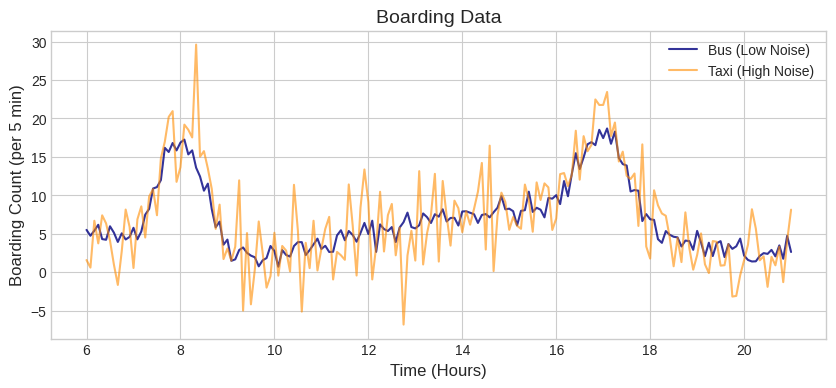

In [24]:
start_min, end_min, interval = 6*60, 21*60, 5
time_pts = np.arange(start_min, end_min + interval, interval)
hours = time_pts / 60

morning_peak = 15 * np.exp(-(hours - 8)**2 / 0.5)
evening_peak = 12 * np.exp(-(hours - 17)**2 / 0.5)
base_traffic = 5 + 3 * np.sin(2 * np.pi * hours / 12)
signal = base_traffic + morning_peak + evening_peak

#Added Differential Noise
np.random.seed(42)
bus_data = signal + np.random.normal(0, 1.0, len(hours))
taxi_data = signal + np.random.normal(0, 4.0, len(hours))

plt.figure(figsize=(10, 4))
plt.plot(hours, bus_data, label='Bus (Low Noise)', color='navy', alpha=0.8)
plt.plot(hours, taxi_data, label='Taxi (High Noise)', color='darkorange', alpha=0.6)
plt.title('Boarding Data', fontsize=14)
plt.xlabel('Time (Hours)', fontsize=12)
plt.ylabel('Boarding Count (per 5 min)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


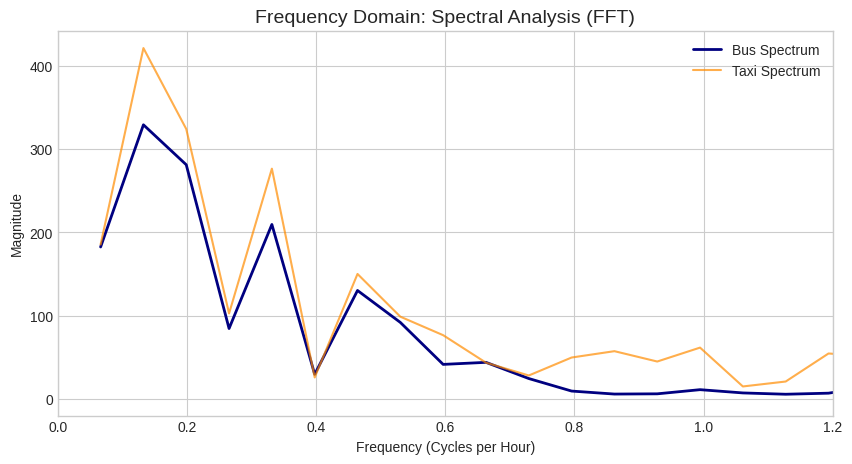

In [25]:
def get_fft_results(data, interval_min):
    n = len(data)

    fft_vals = np.fft.fft(data - np.mean(data))
    freqs = np.fft.fftfreq(n, d=interval_min/60)

    mask = freqs > 0
    return freqs[mask], np.abs(fft_vals[mask])

f_bus, mag_bus = get_fft_results(bus_data, interval)
f_taxi, mag_taxi = get_fft_results(taxi_data, interval)

plt.figure(figsize=(10, 5))
plt.plot(f_bus, mag_bus, label='Bus Spectrum', color='navy', lw=2)
plt.plot(f_taxi, mag_taxi, label='Taxi Spectrum', color='darkorange', lw=1.5, alpha=0.7)

plt.title('Frequency Domain: Spectral Analysis (FFT)', fontsize=14)
plt.xlabel('Frequency (Cycles per Hour)')
plt.ylabel('Magnitude')
plt.xlim(0, 1.2)
plt.grid(True)
plt.legend()
plt.show()

4(b)

In [26]:
#top 3 peaks
def identify_top_peaks(freqs, magnitude, label, n_peaks=3):
    # Find peaks in the magnitude array
    indices, _ = find_peaks(magnitude, height=np.max(magnitude)*0.2, distance=5)

    sorted_indices = indices[np.argsort(magnitude[indices])][::-1][:n_peaks]

    results = []
    for idx in sorted_indices:
        f = freqs[idx]
        results.append({
            "Mode": label,
            "Frequency (cpH)": round(f, 3),
            "Period (Hours)": round(1/f, 2),
            "Magnitude": round(magnitude[idx], 1)
        })
    return results

bus_peaks = identify_top_peaks(f_bus, mag_bus, "Bus")
taxi_peaks = identify_top_peaks(f_taxi, mag_taxi, "Taxi")

df_peaks = pd.DataFrame(bus_peaks + taxi_peaks)
print(df_peaks)

   Mode  Frequency (cpH)  Period (Hours)  Magnitude
0   Bus            0.133            7.54      329.3
1   Bus            0.464            2.15      130.2
2  Taxi            0.133            7.54      421.4
3  Taxi            0.464            2.15      150.1
4  Taxi            1.525            0.66      118.3


4(c)

The Fourier Transform reveals repeating temporal patterns in boarding demand that can be used to optimise transport scheduling.

1) dominant frequency (~0.133 cycles/hour, 7.5-hour period) reflects daily commuting peaks (morning/evening rush).  

- Operators should align full-capacity service blocks with these peaks, ensuring availability during high demand while avoiding over-provision off-peak.

2) secondary frequency (~0.464 cycles/hour, 2.15 hours) indicates mid-day demand fluctuations (school, lunch trips).  

- Operators should deploy additional short-duration services during these intervals instead of max fleet depoloyment all day.

3) Taxis show higher-frequency component (~1.5 cycles/hour, 40 mins) for rapidly varying demand.  

- Fixed schedules are less effective,use dynamic dispatch with real-time data to reposition vehicles and reduce idle time.

# **5. Image Processing for Vehicle Recognition**

5(a) Image Proccessing functions

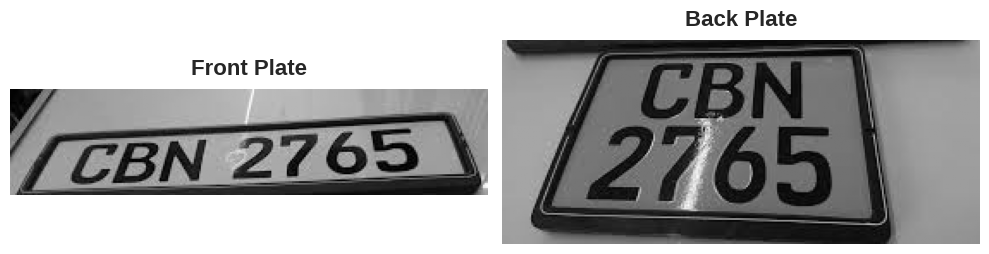

In [27]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Maths CW/vehicle_plate.png"
image_bgr = cv2.imread(img_path)
gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

row_sums = np.sum(gray_image, axis=1)
mid_point = len(row_sums) // 2

split_idx = mid_point - 50 + np.argmin(row_sums[mid_point-50 : mid_point+50])

#Slice the image based on that intensity dip
front_plate = gray_image[0:split_idx, :]
back_plate = gray_image[split_idx:, :]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(front_plate, cmap='gray')
axes[0].set_title("Front Plate", fontsize=16, fontweight='bold', pad=10)
axes[0].axis('off')

axes[1].imshow(back_plate, cmap='gray')
axes[1].set_title("Back Plate", fontsize=16, fontweight='bold', pad=10)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


5(b)

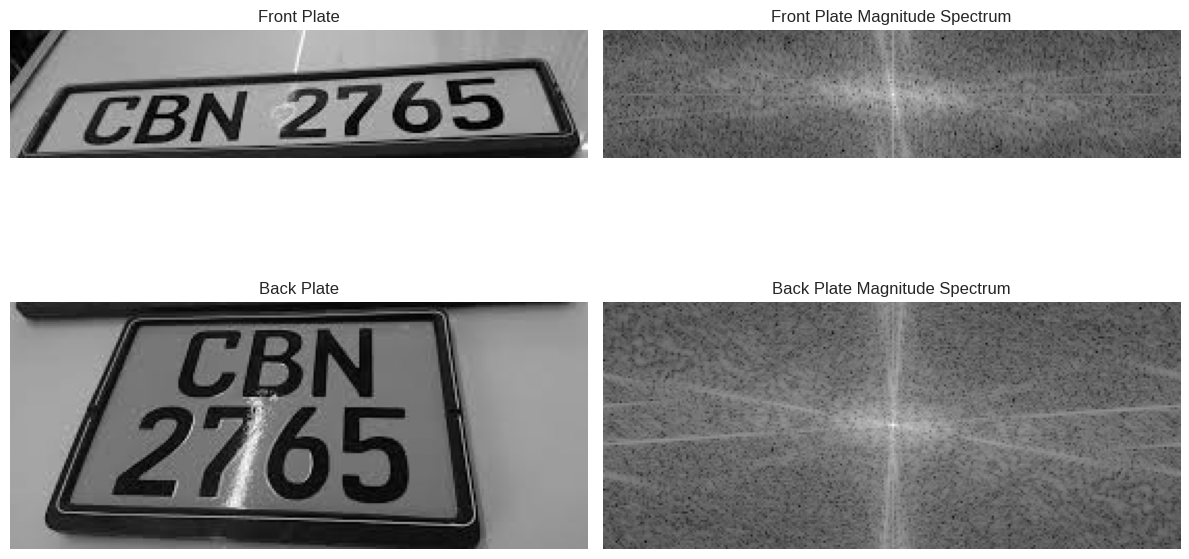

In [29]:
def get_magnitude_spectrum(img):
    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)

    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)

    return magnitude_spectrum

front_spectrum = get_magnitude_spectrum(front_plate)
back_spectrum = get_magnitude_spectrum(back_plate)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(front_plate, cmap='gray')
plt.title("Front Plate")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(front_spectrum, cmap='gray')
plt.title("Front Plate Magnitude Spectrum")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(back_plate, cmap='gray')
plt.title("Back Plate")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(back_spectrum, cmap='gray')
plt.title("Back Plate Magnitude Spectrum")
plt.axis("off")

plt.tight_layout()
plt.show()

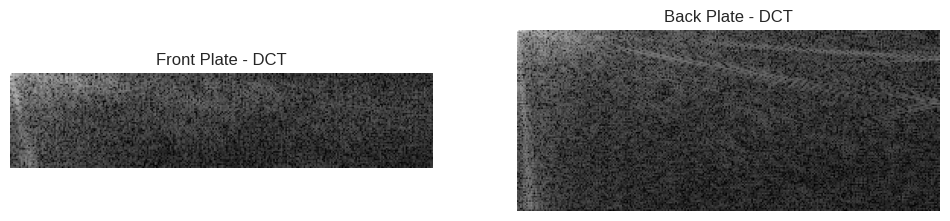

In [30]:
def get_dct_matrix(N):
    #Generates an N x N DCT transformation matrix
    n = np.arange(N)
    k = np.arange(N).reshape((N, 1))
    #Standard DCT-II formula
    M = np.cos(np.pi * k * (2 * n + 1) / (2 * N))

    M[0, :] = M[0, :] * np.sqrt(1/N)
    M[1:, :] = M[1:, :] * np.sqrt(2/N)
    return M

def compute_2d_dct(img):

    h, w = img.shape
    C_h = get_dct_matrix(h)
    C_w = get_dct_matrix(w)
    #The 2D DCT is C_h * Image * C_w_transpose (matrix multiplication)
    return np.dot(C_h, np.dot(img, C_w.T))

front_dct = compute_2d_dct(front_plate)
back_dct = compute_2d_dct(back_plate)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Front Plate - DCT")
plt.imshow(np.log(np.abs(front_dct) + 1), cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Back Plate - DCT")
plt.imshow(np.log(np.abs(back_dct) + 1), cmap='gray')
plt.axis("off")
plt.show()

5(c)

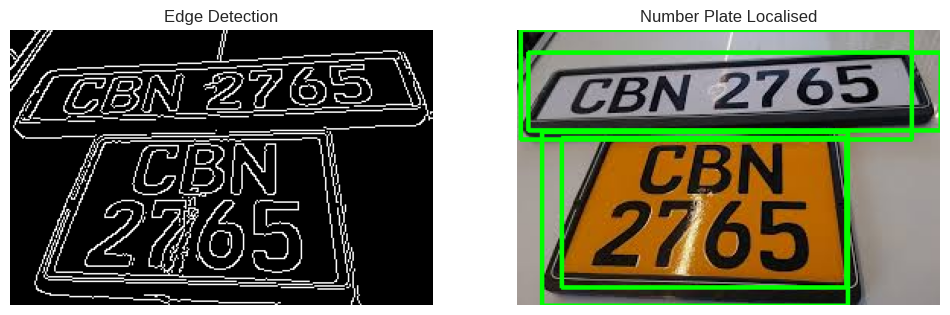

In [32]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Maths CW/vehicle_plate.png"
img_bgr = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 100, 200)

contours, _ = cv2.findContours(
    edges,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

plate_localised = img_rgb.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    if w > 100 and h > 30:
        cv2.rectangle(
            plate_localised,
            (x, y),
            (x + w, y + h),
            (0, 255, 0),
            2
        )

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(plate_localised)
plt.title("Number Plate Localised")
plt.axis("off")

plt.show()

5(d) The Fourier Transform shows how image info spreads across spatial frequencies. Areas that are smooth like the plate background are represented as low-frequency components. The high-frequency ones highlight plate borders, character edges, and text strokes/corners.

The magnitude spectrum  
emphasizes strong edges and patterns, showing plates' horizontal/vertical structure.  

By using the Discrete Cosine Transform (DCT), a large portion of the image energy is accumulated in a small number of low-frequency coefficients and yet still important structural information is retained. This renders it good in capturing the necessary layout of the plate minimizing the noise and redundancy.

Fourier and DCT analysis boost number plate recognition by enhancing edge/character visibility, separating text from background noise, providing compact features for classification, and enabling robust detection under varying lighting. DCT particularly excels at feature extraction and compression, allowing efficient storage and faster plate matching in automated systems.

These transforms power intelligent traffic systems by enabling automated vehicle identification for monitoring, vehicle counting to gauge congestion, peak-hour detection from vehicle frequency, route optimisation with real-time density data, and dynamic signal control/scheduling adjustments.